In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.linalg
import scipy.sparse
import scipy.optimize
import matplotlib

#matplotlib.use('nbagg')

In [160]:
out = pd.read_excel('../2.xlsx')

In [161]:
x = out['Time (min)'].values
t = out['mAu'].values

In [162]:
def als_baseline_correction(x, lam=1e9, p=1e-4, n_iter=3):
    '''
    Asymmetric Least-Squares baseline correction.
    Reference:
        Asymmetric Least Squares Smoothing by P. Eilers and H. Boelens in 2005.
    Notice:
        D = sparse.csc_matrix(np.diff(np.eye(L), 2)) could be used instead.
        However, this dense matrix diff computation could bring about memory issues.
    '''
    L = len(x)
    D = scipy.sparse.diags([1,-2,1],[0,-1,-2], shape=(L, L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = scipy.sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = scipy.sparse.linalg.spsolve(Z, w*x)
        w = p * (x > z) + (1-p) * (x < z)
    return x - z, z

def asymmetrical_gaussian_peak(x, amplitude, loc, s0, s1, s2, s3, s4, s5):
    # assymetrical_gaussian_peak(..., assymetry=0) is the same as gaussian_peak(...)
    return amplitude * np.exp(-1/2*((x - loc)/(
        s0 + s1*(x - loc)))**2)

In [163]:
def obj(param):
    g = asymmetrical_gaussian_peak(t, *param)
    w = np.where(x > 0.01, 1, 1)
    return np.mean(np.square(g - x) * w)

result = scipy.optimize.minimize(obj, x0=np.array([8, 80, 3, 0.01, 0.01, 0.01, 0.01, 0.01]))

In [164]:
foo = result.x[3] * (t - result.x[1])

In [165]:
 max(t)

150.003

In [166]:
int(len(t) * 0.5616378769087785)

12035

In [167]:
idx = np.where(foo > 0)[0]

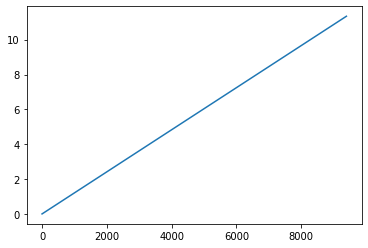

In [168]:
plt.plot(foo[idx])

In [169]:
result.x[2] + result.x[3]

4.94802416851126

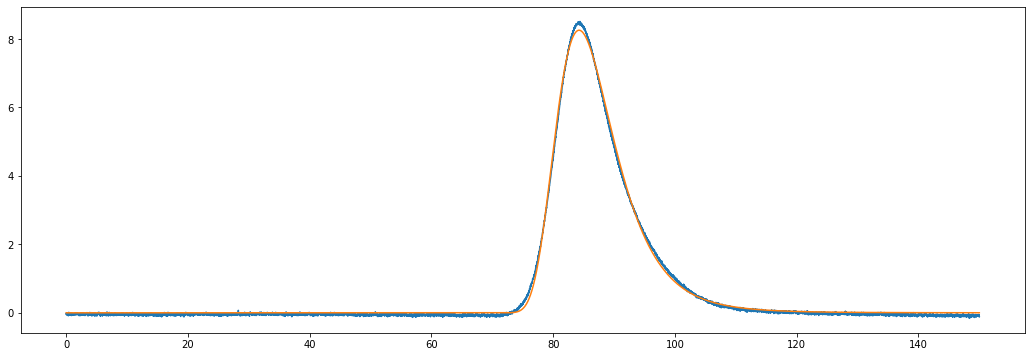

In [170]:
plt.figure(figsize=(18, 6))

z, b = als_baseline_correction(x, 1e14, 1e-2)

plt.plot(t, x)
#plt.plot(z)
#plt.plot(b)
plt.plot(t, asymmetrical_gaussian_peak(t, *result.x))
#plt.axhline(0, color='black');

In [155]:
out = asymmetrical_gaussian_peak(t, *result.x)

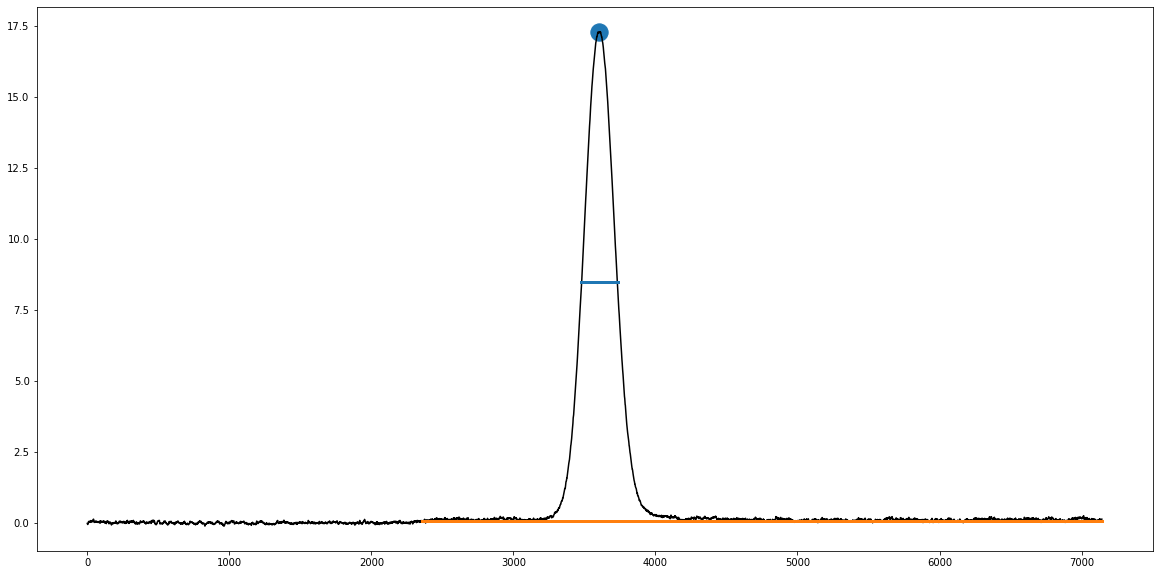

In [159]:
def durbin_watson_criterion(x_orig, x_smooth):
    """DW value closest to 2 is considered to be the optimal"""
    distance_i = x_orig[1:] - x_smooth[1:]
    distance_j = x_orig[:1] - x_smooth[:1]
    oscillation = (distance_i - distance_j) ** 2
    return np.sum(oscillation) / np.sum(distance_i ** 2) * (len(x_orig) / (len(x_orig) - 1))

def savitzky_golay_smoothing(x, window_length, polyorder):
    pass


class PeakFinder:
    
    savgol_param = {
        'window_length': range(5, 2001, 8),
        'polyorder': [2],
    }
    
    def __init__(self, ):
        pass
    
    def _durbin_watson_criterion(self, x_orig, x_smooth):
        """DW value closest to 2 is considered to be the optimal"""
        distance_i = x_orig[1:] - x_smooth[1:]
        distance_j = x_orig[:1] - x_smooth[:1]
        oscillation = (distance_i - distance_j) ** 2
        return np.sum(oscillation) / np.sum(distance_i ** 2) * (len(x_orig) / (len(x_orig) - 1))
    
    def _search_savgol_parameters(self, x):
        best_val = float('inf')
        for order in self.savgol_param['polyorder']:
            for window in self.savgol_param['window_length']:
                z = scipy.signal.savgol_filter(x, window, order)
                val = self._durbin_watson_criterion(x, z)
                if abs(val - 2.) < abs(best_val - 2.):
                    best_val = val
                    best_param = {'window_length': window, 'polyorder': order}
        return best_param
        
    def smooth(self, x):
        param = self._search_savgol_parameters(x)
        return scipy.signal.savgol_filter(x, **param)
    
    def find(self, x):
        z = self.smooth(x)
        peaks, additional = scipy.signal.find_peaks(z, height=[1, None], width=[100, None])
        results_half = scipy.signal.peak_widths(z, peaks, rel_height=0.5)
        results_full = scipy.signal.peak_widths(z, peaks, rel_height=1.0)
        return peaks, results_half, results_full
    
plt.figure(figsize=(20, 10))
peaks, results_half, results_full = PeakFinder().find(x)

plt.scatter(peaks, additional['peak_heights'], s=300)
plt.plot(x, color='black')
plt.plot([results_half[2], results_half[3]], [results_half[1], results_half[1]], linewidth=3)
plt.plot([results_full[2], results_full[3]], [results_full[1], results_full[1]], linewidth=3)


In [157]:
peaks, additional = scipy.signal.find_peaks(x, height=[2, None], width=[100, 10000])

results_half = scipy.signal.peak_widths(x, peaks, rel_height=0.5)

results_full = scipy.signal.peak_widths(x, peaks, rel_height=1.0, wlen=10000)

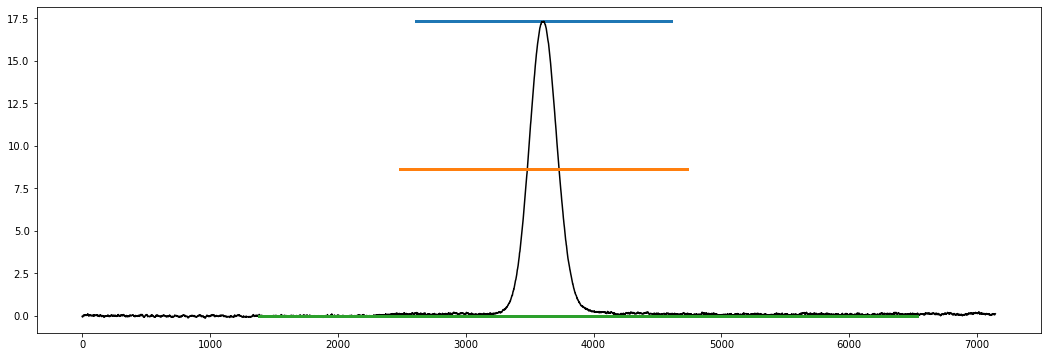

In [158]:
plt.figure(figsize=(18, 6))

#plt.scatter(peaks, x[peaks])
plt.plot([peaks-1000, peaks+1000], [additional['peak_heights'], additional['peak_heights']], linewidth=3)


plt.plot(x, color='black')


#plt.scatter(int(results_half[2]), x[int(results_half[2])], color='red')
#plt.scatter(int(results_half[3]), x[int(results_half[3])], color='red')

plt.plot([results_half[2]-1000, results_half[3]+1000], [results_half[1], results_half[1]], linewidth=3)


#plt.scatter(int(results_full[2]), x[int(results_full[2])], color='green')
#plt.scatter(int(results_full[3]), x[int(results_full[3])], color='green')

plt.plot([results_full[2]-1000, results_full[3]+1000], [results_full[1], results_full[1]], linewidth=3)

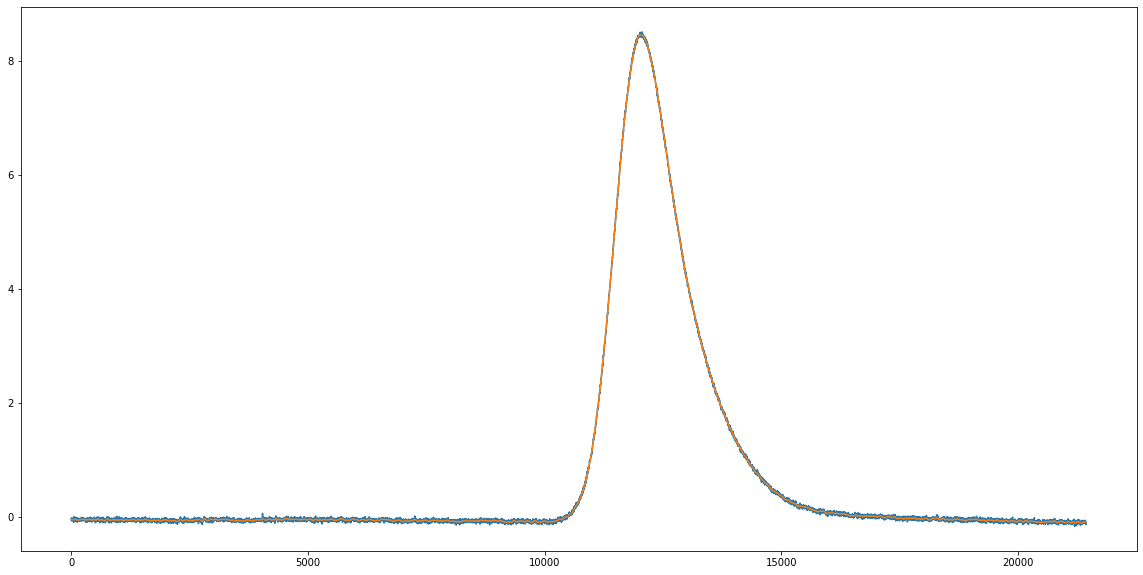

In [109]:
plt.figure(figsize=(20, 10))
z = scipy.signal.savgol_filter(x, window_length=101, polyorder=2)
plt.plot(x)
plt.plot(z)


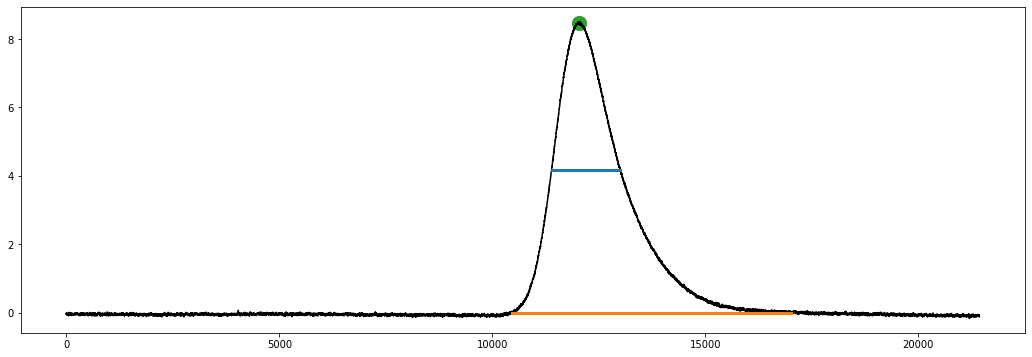

In [110]:
peaks, additional = scipy.signal.find_peaks(z, height=[2, None], width=[100, 10000])

results_half = scipy.signal.peak_widths(z, peaks, rel_height=0.5)

results_full = scipy.signal.peak_widths(z, peaks, rel_height=1.0, wlen=10000)


plt.figure(figsize=(18, 6))

#plt.scatter(peaks, x[peaks])
plt.scatter(peaks, additional['peak_heights'], s=200, color='C2')


plt.plot(x, color='black')


#plt.scatter(int(results_half[2]), x[int(results_half[2])], color='red')
#plt.scatter(int(results_half[3]), x[int(results_half[3])], color='red')

plt.plot([results_half[2], results_half[3]], [results_half[1], results_half[1]], linewidth=3)


#plt.scatter(int(results_full[2]), x[int(results_full[2])], color='green')
#plt.scatter(int(results_full[3]), x[int(results_full[3])], color='green')

plt.plot([results_full[2], results_full[3]], [results_full[1], results_full[1]], linewidth=3)

In [59]:
class PeakFinder:
    
    def __init__(self, ):
        pass
    
    def __call__(self, inputs):
        prev_avg = float('-inf')
        increase = 0
        for i in range(len(inputs)):
            
            moving_average = sum(inputs[i: i+50]) / 50 
            
            if moving_average > prev_avg:
                increase += 1
                
            
            if prev_point < point:
                increase += 1
                
            
            prev_point = point



IndentationError: expected an indented block (219938897.py, line 11)

In [235]:
results_full

(array([13060.20009242]),
 array([-0.13337]),
 array([8128.]),
 array([21188.20009242]))